In [1]:
from selenium import webdriver
from bs4 import BeautifulSoup
import zipfile
import pandas as pd
from io import StringIO
import requests
import csv
import time
import random
import numpy as np

# Creating Dataframe

In [2]:
#pip import xlrx (Python Library extract Excel spreadsheets)

Indiana_url = "https://hub.mph.in.gov/dataset/62ddcb15-bbe8-477b-bb2e-175ee5af8629/resource/2538d7f1-391b-4733-90b3-9e95cd5f3ea6/download/covid_report_demographics.xlsx"
Indiana_totals="https://hub.mph.in.gov/dataset/ab9d97ab-84e3-4c19-97f8-af045ee51882/resource/182b6742-edac-442d-8eeb-62f96b17773e/download/covid_report_date.xlsx"

#historical data for cases and deaths
Indiana_historical = pd.read_excel(Indiana_totals, "Report")

#takes data from the "Race" tab in the spreadsheet
Indiana_race = pd.read_excel(Indiana_url, "Race")

#takes data from the "Ethnicity" tab in the spreadsheet
Indiana_ethnicity = pd.read_excel(Indiana_url, "Ethnicity")

# Data Cleaning

In [3]:
#delete columns which are not used for COVID Racial Data Tracker
Indiana_historical = Indiana_historical[['DATE','COVID_COUNT_CUMSUM','COVID_DEATHS_CUMSUM','COVID_TEST_CUMSUM']]
Indiana_race = Indiana_race.drop(['COVID_TEST_PCT','COVID_COUNT_PCT','COVID_DEATHS_PCT'], 1)
Indiana_ethnicity = Indiana_ethnicity.drop(['COVID_TEST_PCT','COVID_COUNT_PCT','COVID_DEATHS_PCT'], 1)

#renames COVID_COUNT to cases
Indiana_historical.rename(columns = {'COVID_COUNT_CUMSUM':'Cases'}, inplace = True)
Indiana_historical.rename(columns = {'COVID_DEATHS_CUMSUM':'Deaths'}, inplace = True)
Indiana_historical.rename(columns = {'COVID_TEST_CUMSUM':'Tests'}, inplace = True)
Indiana_race.rename(columns = {'COVID_COUNT':'Cases'}, inplace = True)
Indiana_race.rename(columns = {'COVID_TEST':'Tests'}, inplace = True)
Indiana_race.rename(columns = {'COVID_DEATHS':'Deaths'}, inplace = True)
Indiana_ethnicity.rename(columns = {'COVID_COUNT':'Cases'}, inplace = True)
Indiana_ethnicity.rename(columns = {'COVID_TEST':'Tests'}, inplace = True)
Indiana_ethnicity.rename(columns = {'COVID_DEATHS':'Deaths'}, inplace = True)

# #repositioning columns for IN
Indiana_race = Indiana_race[['RACE', 'Cases', 'Deaths', 'Tests']]
Indiana_race.set_index('RACE', inplace=True)

# #repositioning columns for GA
Indiana_ethnicity = Indiana_ethnicity[['ETHNICITY', 'Cases', 'Deaths', 'Tests']]
Indiana_ethnicity.set_index('ETHNICITY', inplace=True)

#reformatting so all column headers are on same row
Indiana_race.columns.name = Indiana_race.index.name
Indiana_race.index.name = None

Indiana_ethnicity.columns.name = Indiana_ethnicity.index.name
Indiana_ethnicity.index.name = None

In [23]:
#in order to get probable deaths which not included directly in dataset
Indiana_probable = pd.read_csv("https://api.covidtracking.com/v1/states/in/current.csv")
probable_deaths=Indiana_probable.loc[0,"deathProbable"]
probable_deaths

301

In [4]:
Indiana_historical['DATE']=pd.to_datetime(Indiana_historical['DATE'],format='%Y-%m-%d')
Indiana_today=Indiana_historical.tail(1).reset_index()
del Indiana_today['index']
Indiana_today

,DATE,Cases,Deaths,Tests
0,2020-12-07,392663,6109,2338308


# Indiana Race Dataframe

In [5]:
Indiana_race

RACE,Cases,Deaths,Tests
Asian,5027,30,42247
Black or African American,26058,584,173279
Other Race,44336,811,265549
Unknown,69436,407,294072
White,247806,4277,1563161


# Indiana Ethnicity Dataframe

In [6]:
Indiana_ethnicity

ETHNICITY,Cases,Deaths,Tests
Hispanic or Latino,26137,141,88534
Not Hispanic or Latino,188418,3165,1077037
Unknown,178108,2803,1172737


# Data Validation

In [7]:
#Difference in sum of cases by race v. Total confirmed cases 
race_v_cases=int(Indiana_historical["Cases"].tail(1)-Indiana_race["Cases"].sum())

#Difference in sum of cases by ethnicity v. Total cases 
ethnicity_v_cases=int(Indiana_historical["Cases"].tail(1)-Indiana_ethnicity["Cases"].sum())

#Difference in sum of deaths by race v. Total deaths
race_v_deaths=int(Indiana_historical["Deaths"].tail(1)-Indiana_race["Deaths"].sum())

#Difference in sum of deaths by ethnicity v. Total deaths
ethnicity_v_deaths=int(Indiana_historical["Deaths"].tail(1)-Indiana_ethnicity["Deaths"].sum())

#Difference in sum of tests by race v. Total individuals tested
race_v_tests=int(Indiana_historical["Tests"].tail(1)-Indiana_race["Tests"].sum())

#Difference in sum of tests by ethnicity v. Total individuals tested
ethnicity_v_tests=int(Indiana_historical["Tests"].tail(1)-Indiana_ethnicity["Tests"].sum())

data_validation= pd.DataFrame({"Difference in sum of cases by race v. Total confirmed cases":[race_v_cases], 
    "Difference in sum of cases by ethnicity v. Total cases":[ethnicity_v_cases],
    "Difference in sum of deaths by race v. Total deaths":[race_v_deaths],
    "Difference in sum of deaths by ethnicity v. Total deaths":[ethnicity_v_deaths],
    "Difference in sum of tests by race v. Total individuals tested":[race_v_tests],
    "Difference in sum of tests by ethnicity v. Total individuals tested":[ethnicity_v_tests]},index=['Data Validation']).T


#Red if values are not equal
data_validation.style.applymap(lambda x: 'background-color : red' if x!=0 else '')

,Data Validation
Difference in sum of cases by race v. Total confirmed cases,0
Difference in sum of cases by ethnicity v. Total cases,0
Difference in sum of deaths by race v. Total deaths,0
Difference in sum of deaths by ethnicity v. Total deaths,0
Difference in sum of tests by race v. Total individuals tested,0
Difference in sum of tests by ethnicity v. Total individuals tested,0


# Historical Indiana Data from CRDT Website

In [9]:
#get data from CRDT website
CRDT_data = "https://docs.google.com/spreadsheets/d/e/2PACX-1vS8SzaERcKJOD_EzrtCDK1dX1zkoMochlA9iHoHg_RSw3V8bkpfk1mpw4pfL5RdtSOyx_oScsUtyXyk/pub?gid=43720681&single=true&output=csv"
df=pd.read_csv(CRDT_data)

#convert data column to datetime data-type
df['Date']= pd.to_datetime(df['Date'].astype(str), format='%Y%m%d')

#filter for Georgia data only and re-index
Indiana_CRDT=df.loc[df['State']=='IN'].reset_index()
Indiana_CRDT.drop('State', inplace=True, axis=1)
del Indiana_CRDT['index']

#Indiana does not report hospitaliztion data, when they start reporting, you can delete the line below
Indiana_CRDT=Indiana_CRDT.drop(Indiana_CRDT.columns.to_series()["Hosp_Total":"Hosp_Ethnicity_Unknown"],axis=1)

#only display 5 most recent records (takes about 15 seconds to load)
Indiana_CRDT.head(5)

,Date,Cases_Total,Cases_White,Cases_Black,Cases_LatinX,Cases_Asian,Cases_AIAN,Cases_NHPI,Cases_Multiracial,Cases_Other,...,Tests_LatinX,Tests_Asian,Tests_AIAN,Tests_NHPI,Tests_Multiracial,Tests_Other,Tests_Unknown,Tests_Ethnicity_Hispanic,Tests_Ethnicity_NonHispanic,Tests_Ethnicity_Unknown
0,2020-12-06,381617,241487,25489.0,NaN,4880.0,NaN,NaN,NaN,42977.0,...,NaN,41792.0,NaN,NaN,NaN,263976.0,286476.0,87096.0,1060610.0,1162173.0
1,2020-12-02,350970,223543,24121.0,NaN,4534.0,NaN,NaN,NaN,39954.0,...,NaN,40458.0,NaN,NaN,NaN,259122.0,265502.0,83583.0,1015458.0,1133061.0
2,2020-11-29,333312,209048,22837.0,NaN,4298.0,NaN,NaN,NaN,37559.0,...,NaN,39503.0,NaN,NaN,NaN,251638.0,277435.0,81600.0,990784.0,1116544.0
3,2020-11-25,312521,197228,21859.0,NaN,4060.0,NaN,NaN,NaN,35446.0,...,NaN,38578.0,NaN,NaN,NaN,247764.0,258720.0,79161.0,957755.0,1089479.0
4,2020-11-22,295357,182097,20548.0,NaN,3787.0,NaN,NaN,NaN,33415.0,...,NaN,37538.0,NaN,NaN,NaN,238592.0,273565.0,76752.0,926674.0,1069264.0


# Converting New Scraped Covid Data into Same Format as CRDT Table

In [24]:
column_names = ["Date","Cases_Total","Cases_White","Cases_Black","Cases_LatinX","Cases_Asian",
                "Cases_AIAN","Cases_NHPI","Cases_Multiracial","Cases_Other","Cases_Unknown",
                "Cases_Ethnicity_Hispanic","Cases_Ethnicity_NonHispanic","Cases_Ethnicity_Unknown",
                "Deaths_Total","Deaths_White","Deaths_Black","Deaths_LatinX","Deaths_Asian",
               "Deaths_AIAN","Deaths_NHPI","Deaths_Multiracial","Deaths_Other","Deaths_Unknown",
               "Deaths_Ethnicity_Hispanic","Deaths_Ethnicity_NonHispanic","Deaths_Ethnicity_Unknown","Tests_Total",
               "Tests_White","Tests_Black","Tests_Asian","Tests_Other","Tests_Unknown","Tests_Ethnicity_Hispanic",
               "Tests_Ethnicity_NonHispanic","Tests_Ethnicity_Unknown"]

#new_data is the dataframe for the new data which you just scraped converted into data format of Indiana_CRDT
new_data = pd.DataFrame(columns = column_names)

new_data["Date"]=[Indiana_today.loc[0,"DATE"]]
new_data["Cases_Total"]=[Indiana_today.loc[0,"Cases"]]
new_data["Cases_White"]=[Indiana_race.loc["White","Cases"]]
new_data["Cases_Black"]=[Indiana_race.loc["Black or African American","Cases"]]
new_data["Cases_Asian"]=[Indiana_race.loc["Asian","Cases"]]
new_data["Cases_Other"]=[Indiana_race.loc["Other Race","Cases"]]
new_data["Cases_Unknown"]=[Indiana_race.loc["Unknown","Cases"]]
new_data["Cases_Ethnicity_Hispanic"]=[Indiana_ethnicity.loc["Hispanic or Latino","Cases"]]
new_data["Cases_Ethnicity_NonHispanic"]=[Indiana_ethnicity.loc["Not Hispanic or Latino","Cases"]]
new_data["Cases_Ethnicity_Unknown"]=[Indiana_ethnicity.loc["Unknown","Cases"]]

#250 is a placeholder for probable deaths will be replaced once found
new_data["Deaths_Total"]=[Indiana_today.loc[0,"Deaths"]+probable_deaths]
new_data["Deaths_White"]=[Indiana_race.loc["White","Deaths"]]
new_data["Deaths_Black"]=[Indiana_race.loc["Black or African American","Deaths"]]
new_data["Deaths_Asian"]=[Indiana_race.loc["Asian","Deaths"]]
new_data["Deaths_Other"]=[Indiana_race.loc["Other Race","Deaths"]]
new_data["Deaths_Unknown"]=[(new_data["Deaths_Total"]-new_data["Deaths_White"]-new_data["Deaths_Black"]-
                           new_data["Deaths_Asian"]-new_data["Deaths_Other"]).iloc[0]]

new_data["Deaths_Ethnicity_Hispanic"]=[Indiana_ethnicity.loc["Hispanic or Latino","Deaths"]]
new_data["Deaths_Ethnicity_NonHispanic"]=[Indiana_ethnicity.loc["Not Hispanic or Latino","Deaths"]]
new_data["Deaths_Ethnicity_Unknown"]=[(new_data["Deaths_Total"]-new_data["Deaths_Ethnicity_Hispanic"]-
                                     new_data["Deaths_Ethnicity_NonHispanic"]).iloc[0]]

new_data["Tests_Total"]=[Indiana_today.loc[0,"Tests"]]
new_data["Tests_White"]=[Indiana_race.loc["White","Tests"]]
new_data["Tests_Black"]=[Indiana_race.loc["Black or African American","Tests"]]
new_data["Tests_Asian"]=[Indiana_race.loc["Asian","Tests"]]
new_data["Tests_Other"]=[Indiana_race.loc["Other Race","Tests"]]
new_data["Tests_Unknown"]=[Indiana_race.loc["Unknown","Tests"]]
new_data["Tests_Ethnicity_Hispanic"]=[Indiana_ethnicity.loc["Hispanic or Latino","Tests"]]
new_data["Tests_Ethnicity_NonHispanic"]=[Indiana_ethnicity.loc["Not Hispanic or Latino","Tests"]]
new_data["Tests_Ethnicity_Unknown"]=[Indiana_ethnicity.loc["Unknown","Tests"]]

new_data

,Date,Cases_Total,Cases_White,Cases_Black,Cases_LatinX,Cases_Asian,Cases_AIAN,Cases_NHPI,Cases_Multiracial,Cases_Other,...,Deaths_Ethnicity_Unknown,Tests_Total,Tests_White,Tests_Black,Tests_Asian,Tests_Other,Tests_Unknown,Tests_Ethnicity_Hispanic,Tests_Ethnicity_NonHispanic,Tests_Ethnicity_Unknown
0,2020-12-07,392663,247806,26058,NaN,5027,NaN,NaN,NaN,44336,...,3104,2338308,1563161,173279,42247,265549,294072,88534,1077037,1172737


# Appending the New Scraped Data to CRDT Indiana Historical Data

In [25]:
#Indiana_Last is the data from the CRDT IN Historical data which you want to compare with new scraped data in time series

#Because CRDT are every Wednesday and Sunday Night. 
#So if you are running the Scrpaer on a Wednesday or Sunday Night, 
    #there will be zero difference in new scraped data and historical data from CRDT
    #So I put the second most recent data for scrpaer to compare with as a way to avoid getting zero. 
    
Indiana_Last_Shift=Indiana_CRDT.loc[[0]] 

#Append the new scraped data and historical data.
append_data=Indiana_Last_Shift.append(new_data, ignore_index=True)

#Set index as date and all datatype as a number. 
append_data.set_index('Date', inplace=True)
append_data=append_data.astype('float64')

#used to calculated the number of days between scrpaer data and last CRDT shift
datediff=(append_data.index[1]-append_data.index[0])/np.timedelta64(1, 'D')

append_data.index=append_data.index.date
append_data.T

,2020-12-06,2020-12-07
Cases_Total,381617.0,392663.0
Cases_White,241487.0,247806.0
Cases_Black,25489.0,26058.0
Cases_LatinX,NaN,NaN
Cases_Asian,4880.0,5027.0
Cases_AIAN,NaN,NaN
Cases_NHPI,NaN,NaN
Cases_Multiracial,NaN,NaN
Cases_Other,42977.0,44336.0
Cases_Unknown,66784.0,69436.0


# Check for Changes in % of Reporting for Race Data

In [26]:
perc_cases = pd.DataFrame()
perc_cases['Cases % Reported']=((1-append_data['Cases_Unknown']/append_data['Cases_Total'])*100)
perc_cases['Deaths % Reported']=((1-append_data['Deaths_Unknown']/append_data['Deaths_Total'])*100)

#change to red if % reported changes by more than 3% since last data shift
perc_cases.round(1).style.apply(lambda x: ["background: red" if v >= x.iloc[0]+3 else "" for v in x], axis=0)

,Cases % Reported,Deaths % Reported
2020-12-06,82.500000,89.100000
2020-12-07,82.300000,89.000000


# Time Series Diffs Check (amount by which each category increased)

In [27]:
#This data quality checker is to simulate the first tab of the Google Sheet used by CRDT for TimeSeries checks. 

# the .T means transpose, so that it is easier to read. If you do not want to transpose, simply delete the .T
diffs = append_data.diff().T

#Orange cells means the category has decreased
#Red cells decreased by more than 100
diffs.style.applymap(lambda x: 'background-color : orange' if x<0 and x>-100 else '').\
applymap(lambda x: 'background-color : red' if x<-100 or x==100 else '')

,2020-12-06,2020-12-07
Cases_Total,nan,11046.000000
Cases_White,nan,6319.000000
Cases_Black,nan,569.000000
Cases_LatinX,nan,nan
Cases_Asian,nan,147.000000
Cases_AIAN,nan,nan
Cases_NHPI,nan,nan
Cases_Multiracial,nan,nan
Cases_Other,nan,1359.000000
Cases_Unknown,nan,2652.000000


# Time Series %ofSelf Check (percent by which each category has increased)

In [28]:
#This data quality checker is to simulate the second tab of the Google Sheet used by CRDT for TimeSeries checks. 

# the .T means transpose, so that it is easier to read. If you do not want to transpose, simply delete the .T
#The *100 is to go from a decimal to a percentage
perc_diff = append_data.pct_change().T*100

#yellow >5% per day since last shift
#orange >10% per day since last shift
#red >20% per day since last shift
perc_diff.style.applymap(lambda x: 'background-color : yellow' if abs(x)>(5*datediff) and abs(x)<(10*datediff) else '').\
applymap(lambda x: 'background-color : orange' if abs(x)>(10*datediff) and abs(x)<(20*datediff) else '').\
applymap(lambda x: 'background-color : red' if abs(x)>(20*datediff) else '')

,2020-12-06,2020-12-07
Cases_Total,nan,2.894525
Cases_White,nan,2.616704
Cases_Black,nan,2.232336
Cases_LatinX,nan,nan
Cases_Asian,nan,3.012295
Cases_AIAN,nan,nan
Cases_NHPI,nan,nan
Cases_Multiracial,nan,nan
Cases_Other,nan,3.162157
Cases_Unknown,nan,3.971011


# Time Series %ofTotal (percent by which percent-of-total that category increased)

In [29]:
#This data quality checker is to simulate the third tab of the Google Sheet used by CRDT for TimeSeries checks. 

#First have to divide up the append_data into 6 different dataframes(Total Cases, Race Cases, Ethnicity Cases...etc)
#Each of the six dataframes should sum up to either to total cases or total deaths. 
#Then can divide each category by the total sum of each category to find the percentage
#Then compare the percentage of total for each category with new data and last first to find percent_difference
#A simple example would be if Total Cases was 1000, then Hispanic cases 200, Non-Hispanic Cases are 500,
    #and unknown ethnicity was 300. Hispanic cases is 20%, Non-Hispanic Cases is 50%, and Unknown is 30%. 
    #then you would compare with the previous shift percentages to determine percentage change. 

#Total Cases
Cases_Total_PCT=append_data[['Cases_Total']].div(append_data[['Cases_Total']].sum(axis=1), axis=0)
Cases_Total_PCT=Cases_Total_PCT.pct_change()*100

#Race Cases
Cases_Race=append_data[['Cases_White','Cases_Black','Cases_LatinX','Cases_Asian','Cases_AIAN',
             'Cases_NHPI','Cases_Multiracial','Cases_Other','Cases_Unknown']]
Cases_Race_PCT = Cases_Race.div(Cases_Race.sum(axis=1), axis=0)
Cases_Race_PCT=Cases_Race_PCT.pct_change()*100

#Ethnicity Cases
Cases_Ethnicity=append_data[["Cases_Ethnicity_Hispanic","Cases_Ethnicity_NonHispanic","Cases_Ethnicity_Unknown"]]
Cases_Ethnicity_PCT = Cases_Ethnicity.div(Cases_Ethnicity.sum(axis=1), axis=0)
Cases_Ethnicity_PCT=Cases_Ethnicity_PCT.pct_change()*100

#Total Deaths 
Deaths_Total_PCT=append_data[['Deaths_Total']].div(append_data[['Deaths_Total']].sum(axis=1), axis=0)
Deaths_Total_PCT=Deaths_Total_PCT.pct_change()*100

#Race Deaths
Deaths_Race=append_data[['Deaths_White','Deaths_Black','Deaths_LatinX','Deaths_Asian','Deaths_AIAN',
             'Deaths_NHPI','Deaths_Multiracial','Deaths_Other','Deaths_Unknown']]
Deaths_Race_PCT = Deaths_Race.div(Deaths_Race.sum(axis=1), axis=0)
Deaths_Race_PCT=Deaths_Race_PCT.pct_change()*100

#Ethnicity Cases
Deaths_Ethnicity=append_data[["Deaths_Ethnicity_Hispanic","Deaths_Ethnicity_NonHispanic","Deaths_Ethnicity_Unknown"]]
Deaths_Ethnicity_PCT = Deaths_Ethnicity.div(Deaths_Ethnicity.sum(axis=1), axis=0)
Deaths_Ethnicity_PCT=Deaths_Ethnicity_PCT.pct_change()*100


Perc_Total=pd.concat([Cases_Total_PCT,Cases_Race_PCT,Cases_Ethnicity_PCT,Deaths_Total_PCT,
                         Deaths_Race_PCT,Deaths_Ethnicity_PCT], axis=1).T

#Yellow cells have changed by more than 2% per day since last shift
#Orange cells have changed by more than 5% per day since last shift
#Red cells have changed by 10% per day since last shift
#Green are new categorys (Have not attempted yet)
Perc_Total.style.applymap(lambda x: 'background-color : yellow' if abs(x)>(2*datediff) and abs(x)<(5*datediff) else '').\
applymap(lambda x: 'background-color : orange' if abs(x)>(5*datediff) and abs(x)<(10*datediff) else '').\
applymap(lambda x: 'background-color : red' if abs(x)>(10*datediff) else '')

,2020-12-06,2020-12-07
Cases_Total,nan,0.000000
Cases_White,nan,-0.270006
Cases_Black,nan,-0.643562
Cases_LatinX,nan,nan
Cases_Asian,nan,0.114457
Cases_AIAN,nan,nan
Cases_NHPI,nan,nan
Cases_Multiracial,nan,nan
Cases_Other,nan,0.260103
Cases_Unknown,nan,1.046203


In [30]:
# Thinking about including a fourth time series check which is the fourth tab of CRDT time series checker 'Summary'

# CRDT Dashboard Changes

In [31]:
#percentage of cases for race
Cases_Race=append_data[['Cases_Black','Cases_Asian','Cases_White','Cases_Other']]
Cases_Race_PCT = (Cases_Race.div(Cases_Race.sum(axis=1), axis=0)*100).round(1).T

#2018 ACS population data
Asian_population=144991
Black_population=619472
Other_population=144648
White_population=5548277

Population=pd.DataFrame({"Percentage of population":[Black_population,Asian_population,White_population,Other_population]}
                       ).set_index(Cases_Race_PCT.index)
Perc_of_pop=(Population.div(Population.sum(axis=0), axis=1)*100).round(1)
CRDT_cases=pd.concat([Perc_of_pop, Cases_Race_PCT], axis=1)
#highlight red if Racial/ethnic disparity is likely (33% higher percentage than population percentage)
#highlight light yellow if data cannot be compared with population
CRDT_cases.style.apply(lambda x: ["background: red" if v > x.iloc[0]*1.33 else "" for v in x], axis=1).\
apply(lambda x: ['background-color : lightyellow' if x.name=="Cases_Other" else '' for i in x],axis=1)

,Percentage of population,2020-12-06,2020-12-07
Cases_Black,9.600000,8.100000,8.100000
Cases_Asian,2.200000,1.600000,1.600000
Cases_White,85.900000,76.700000,76.700000
Cases_Other,2.200000,13.700000,13.700000


In [32]:
#percentage of cases for ethnicity
Cases_Ethnicity=append_data[['Cases_Ethnicity_Hispanic','Cases_Ethnicity_NonHispanic']]
Cases_Ethnicity_PCT = (Cases_Ethnicity.div(Cases_Ethnicity.sum(axis=1), axis=0)*100).round().T

Hispanic_population=472419
NonHispanic_population=6219459

Population=pd.DataFrame({"Percentage of population":[Hispanic_population,NonHispanic_population]}
                       ).set_index(Cases_Ethnicity_PCT.index)
Perc_of_pop=(Population.div(Population.sum(axis=0), axis=1)*100).round(1)
CRDT_cases_ethnicity=pd.concat([Perc_of_pop, Cases_Ethnicity_PCT], axis=1)
CRDT_cases_ethnicity.style.apply(lambda x: ["background: red" if v > x.iloc[0]*1.33 else "" for v in x], axis=1)

,Percentage of population,2020-12-06,2020-12-07
Cases_Ethnicity_Hispanic,7.100000,12.000000,12.000000
Cases_Ethnicity_NonHispanic,92.900000,88.000000,88.000000


In [33]:
#percentage of deaths for race
Deaths_Race=append_data[['Deaths_Black','Deaths_Asian','Deaths_White','Deaths_Other']]
Deaths_Race_PCT = (Deaths_Race.div(Deaths_Race.sum(axis=1), axis=0)*100).round(1).T

#2018 ACS population data
Asian_population=144991
Black_population=619472
Other_population=144648
White_population=5548277

Population=pd.DataFrame({"Percentage of population":[Black_population,Asian_population,White_population,Other_population]}
                       ).set_index(Deaths_Race_PCT.index)
Perc_of_pop=(Population.div(Population.sum(axis=0), axis=1)*100).round(1)
CRDT_deaths=pd.concat([Perc_of_pop, Deaths_Race_PCT], axis=1)
CRDT_deaths.style.apply(lambda x: ["background: red" if v > x.iloc[0]*1.33 else "" for v in x], axis=1).\
apply(lambda x: ['background-color : lightyellow' if x.name=="Deaths_Other" else '' for i in x],axis=1)

,Percentage of population,2020-12-06,2020-12-07
Deaths_Black,9.600000,10.300000,10.200000
Deaths_Asian,2.200000,0.500000,0.500000
Deaths_White,85.900000,75.000000,75.000000
Deaths_Other,2.200000,14.200000,14.200000


In [34]:
#percentage of deaths for ethnicity
Deaths_Ethnicity=append_data[['Deaths_Ethnicity_Hispanic','Deaths_Ethnicity_NonHispanic']]
Deaths_Ethnicity_PCT = (Deaths_Ethnicity.div(Deaths_Ethnicity.sum(axis=1), axis=0)*100).round().T

Hispanic_population=472419
NonHispanic_population=6219459

Population=pd.DataFrame({"Percentage of population":[Hispanic_population,NonHispanic_population]}
                       ).set_index(Deaths_Ethnicity_PCT.index)
Perc_of_pop=(Population.div(Population.sum(axis=0), axis=1)*100).round(1)
CRDT_deaths_ethnicity=pd.concat([Perc_of_pop, Deaths_Ethnicity_PCT], axis=1)
CRDT_deaths_ethnicity.style.apply(lambda x: ["background: red" if v > x.iloc[0]*1.33 else "" for v in x], axis=1)

,Percentage of population,2020-12-06,2020-12-07
Deaths_Ethnicity_Hispanic,7.100000,4.000000,4.000000
Deaths_Ethnicity_NonHispanic,92.900000,96.000000,96.000000


# Per Capita Bar Chart: Cases per 100k people

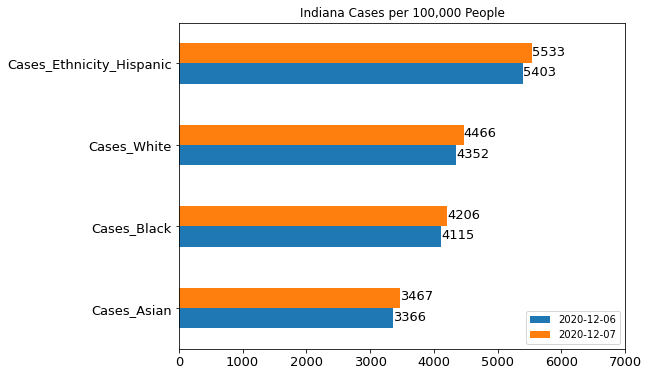

In [36]:
#2018 ACS population data
Asian_population=144991
Black_population=619472
Other_population=144648
White_population=5548277

White_cases_per_cap=pd.DataFrame((append_data['Cases_White']/White_population*100000).round()).T
Black_cases_per_cap=pd.DataFrame((append_data['Cases_Black']/Black_population*100000).round()).T
Hispanic_cases_per_cap=pd.DataFrame((append_data['Cases_Ethnicity_Hispanic']/Hispanic_population*100000).round()).T
Asian_cases_per_cap=pd.DataFrame((append_data["Cases_Asian"]/Asian_population*100000).round()).T

Cases_per_cap=pd.concat([White_cases_per_cap, Black_cases_per_cap,Hispanic_cases_per_cap,Asian_cases_per_cap], axis=0)
Cases_per_cap=Cases_per_cap.sort_values(Cases_per_cap.columns[1],ascending=True)
ax=Cases_per_cap.plot.barh(figsize=(8, 6),title="Indiana Cases per 100,000 People",fontsize=13)

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.3, i.get_y()+.1, \
            int((i.get_width())), fontsize=13,
color='black')

ax=ax.set_xlim(0,7000)

# Per Capita Bar Chart: Deaths per 100k people

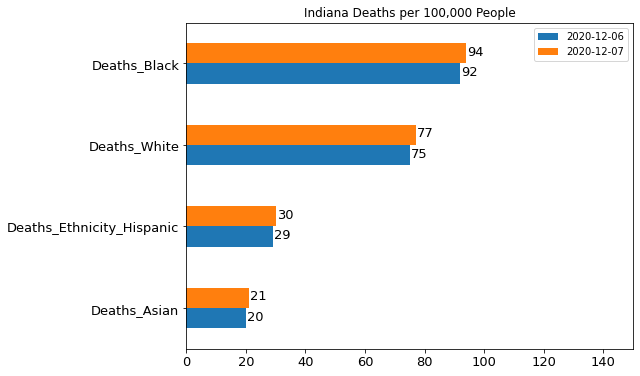

In [38]:
White_deaths_per_cap=pd.DataFrame((append_data['Deaths_White']/White_population*100000).round()).T
Black_deaths_per_cap=pd.DataFrame((append_data['Deaths_Black']/Black_population*100000).round()).T
Hispanic_deaths_per_cap=pd.DataFrame((append_data['Deaths_Ethnicity_Hispanic']/Hispanic_population*100000).round()).T
Asian_deaths_per_cap=pd.DataFrame((append_data["Deaths_Asian"]/Asian_population*100000).round()).T

Deaths_per_cap=pd.concat([White_deaths_per_cap, Black_deaths_per_cap,Hispanic_deaths_per_cap,Asian_deaths_per_cap], axis=0).astype(int)
Deaths_per_cap=Deaths_per_cap.sort_values(Deaths_per_cap.columns[1],ascending=True)
ax=Deaths_per_cap.plot.barh(figsize=(8, 6),title="Indiana Deaths per 100,000 People",fontsize=13)

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.3, i.get_y()+.1, \
            int((i.get_width())), fontsize=13,
color='black')

ax=ax.set_xlim(0,150)


# Testing Data Visualizations for Percent of Change

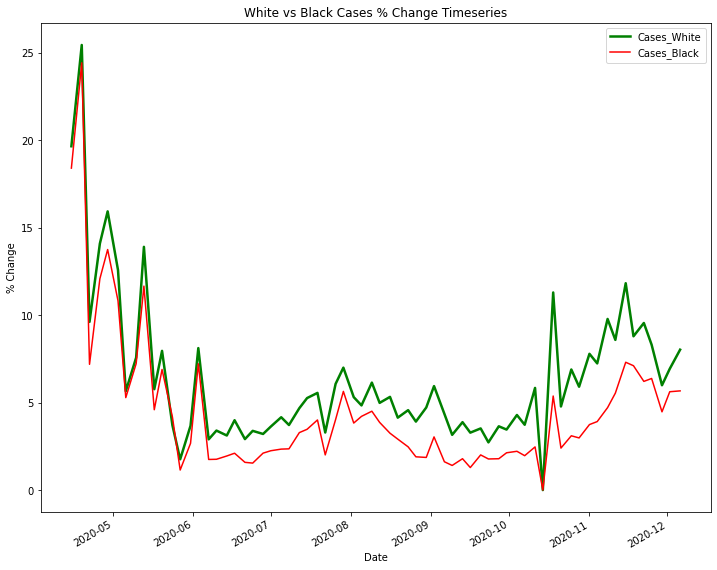

In [39]:
#Percent change for each CRDT data entry shift for White Cases vs Black Cases
cases_white = Indiana_CRDT[['Date','Cases_White']].sort_values(by='Date')
cases_white.set_index('Date', inplace=True)
cases_white=cases_white.astype('float64')
cases_white_pct=cases_white.pct_change()*100

cases_black = Indiana_CRDT[['Date','Cases_Black']].sort_values(by='Date')
cases_black.set_index('Date', inplace=True)
cases_black=cases_black.astype('float64')
cases_black_pct=cases_black.pct_change()*100

ax=cases_white_pct.plot(figsize=(12, 10), title='White vs Black Cases % Change Timeseries',linewidth=2.5, color='green'
                     ,ylabel='% Change',xlabel='Date')

dx=cases_black_pct.plot(ax=ax, color='red')

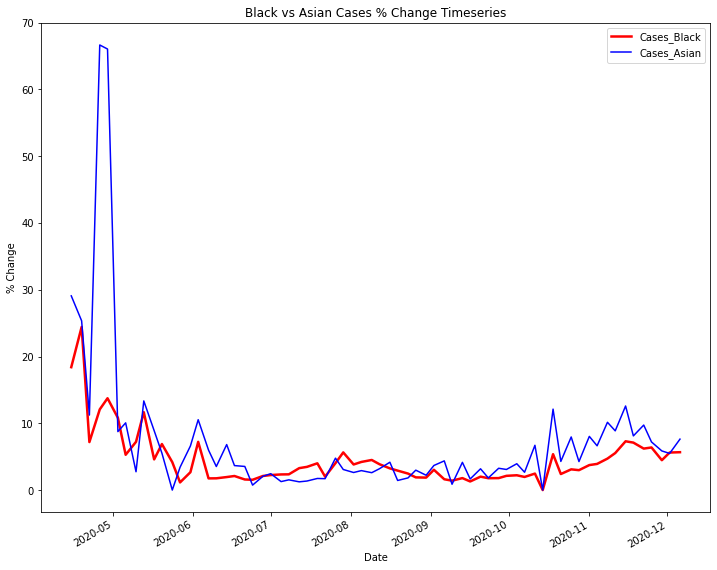

In [40]:
#Percent change for each CRDT data entry shift for Black Cases vs Asian Cases
cases_black = Indiana_CRDT[['Date','Cases_Black']].sort_values(by='Date')
cases_black.set_index('Date', inplace=True)
cases_black=cases_black.astype('float64')
cases_black_pct=cases_black.pct_change()*100

cases_asian = Indiana_CRDT[['Date','Cases_Asian']].sort_values(by='Date')
cases_asian.set_index('Date', inplace=True)
cases_asian=cases_asian.astype('float64')
cases_asian_pct=cases_asian.pct_change()*100

ax=cases_black_pct.plot(figsize=(12, 10), title='Black vs Asian Cases % Change Timeseries',linewidth=2.5, color='red'
                     ,ylabel='% Change',xlabel='Date')
dx=cases_asian_pct.plot(ax=ax, color='blue')

# Summary Statistics for Percentage Change for Each Race and Ethnicity

In [52]:
Indiana_CRDT_Sorted=Indiana_CRDT.set_index('Date').sort_index()
Indiana_CRDT_Sorted=Indiana_CRDT_Sorted.astype('float64')
Indiana_CRDT_PCT=Indiana_CRDT_Sorted.pct_change()*100
Indiana_CRDT_PCT.describe(include='all').T

C:\Users\wjg39\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\numpy\lib\function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


,count,mean,std,min,25%,50%,75%,max
Cases_Total,68.0,5.944654,4.322921,1.642976,3.284097,4.596268,6.653208,25.209427
Cases_White,68.0,6.401031,4.206310,0.000000,3.698027,5.287148,7.832660,25.447628
Cases_Black,68.0,4.509969,4.054375,0.000000,2.010751,3.268081,5.562875,24.428934
Cases_LatinX,66.0,2.303634,11.222086,0.000000,0.000000,0.000000,0.000000,74.148607
Cases_Asian,68.0,7.296898,11.509391,0.000000,2.567729,4.048367,7.975675,66.666667
Cases_AIAN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cases_NHPI,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cases_Multiracial,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cases_Other,68.0,5.965024,5.855036,0.000000,2.772590,3.485333,6.353714,27.176781
Cases_Unknown,68.0,5.977966,12.361680,-17.471410,-0.959562,6.171992,9.740681,81.363904


# Create a csv for today's scrpaer data

In [45]:
#to make the CSV based for just this scraper
new_data.insert(1,column='State',value=['IN'])
new_data.to_csv(r"C:\Users\wjg39\Documents\Desktop\CRDT\IN\\"+str(new_data["Date"].loc[0].date())+"_race-ethnicity_Indiana.csv", index = False)

# Add today's scraper data to historical data

In [44]:
#to append new data to the csv of all historical
new_data.insert(1,column='State',value=['IN'])
new_data.to_csv(r'C:\Users\wjg39\Documents\Desktop\CRDT\IN\historical_race-ethnicity_Indiana.csv', mode='a', header=False,index=False)